In [2]:
!pip install wandb

     |████████████████████████████████| 2.2 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 267 kB 16.4 MB/s eta 0:00:01
     |████████████████████████████████| 207 kB 23.7 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 4.3 MB/s  eta 0:00:01
     |████████████████████████████████| 143 kB 20.4 MB/s eta 0:00:01
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.9
    Uninstalling urllib3-1.26.9:
      Successfully uninstalled urllib3-1.26.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


In [4]:
!pip install cvxpy

     |████████████████████████████████| 1.1 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 1.3 MB/s eta 0:00:011
     |████████████████████████████████| 254 kB 534 kB/s eta 0:00:01
     |████████████████████████████████| 456 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 234 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 108 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 108 kB 4.5 MB/s eta 0:00:01


In [1]:
import wandb
import torch
import numpy as np
import networkx as nx
import agent as fba
import env as fbe
from PIL import Image
from tqdm import tqdm
from matplotlib import cm
from torch.utils.data import DataLoader

In [2]:
def main(config):
    use_cuda = torch.cuda.is_available()
    config['device'] = torch.device("cuda" if use_cuda else "cpu")
    rng = torch.Generator(device=config['device'])
    rng.manual_seed(config['seed'])

    # Create dataset
    env = config['env'].split('-')[0]
    if env == "HomoBandit":
        train_data = fbe.HomoBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            np.random.default_rng(
                int(config['env'].split('-')[-1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfActBandit':
        train_data = fbe.StoActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfFixActBandit':
        train_data = fbe.FixActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    else:
        raise NotImplementedError("The "+env+" environment has not been implemented.")
    
    train_loader = DataLoader(
        train_data,
        batch_size=1, 
        shuffle=False
    )
    # compute cumulative loss of the best arm in hindsight
    best_cumu_loss = train_data.cumloss_of_best_arm()

    # Specify communcation network
    network = config['network'].split('-')[0]
    if network == 'COMPLETE':
        graph = nx.complete_graph(config['n_agents'])
    elif network == 'PATH':
        graph = nx.path_graph(config['n_agents'])
    elif network == 'NONE':
        graph = nx.from_numpy_array(
            np.zeros([
                config['n_agents'], config['n_agents']
            ])
        )
    elif network == 'GRID':
        graph = nx.grid_graph([
            int(np.sqrt(config['n_agents'])),
            int(np.sqrt(config['n_agents']))
        ])
    elif network == 'RGG':
        r = float(config['network'].split('-')[1])
        # threshold = np.sqrt(np.log(config['n_agents']) ** 1.1 / config['n_agents'])
        # if r  < threshold:
        #     raise ValueError(
        #         'Please choose r >= ' + str(threshold)
        #     )
        graph = nx.random_geometric_graph(
            config['n_agents'], 
            r,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    elif network == 'ER':
        p = float(config['network'].split('-')[1])
        graph = nx.fast_gnp_random_graph(
            config['n_agents'], 
            p,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    else:
        raise NotImplementedError("The "+config['network']+" network has not been implemented.")
    comm_net = fba.CommNet(graph)

    # Specify the gossip
    if config['network'] == 'NONE':
        gossip_numpy = np.eye(config['n_agents'])
        spectral_gap = 0
    elif config['gossip'] == 'MaxDegree':
        gossip_numpy, spectral_gap = comm_net.max_deg_gossip(spectral_gap=True)
    elif config['gossip'] == 'Fast-SDP':
        gossip_numpy, spectral_gap = comm_net.fast_gossip('SDP', spectral_gap=True)
    else:
        raise NotImplementedError("The "+config['gossip']+" mechanism has not been implemented.")
    gossip = torch.tensor(gossip_numpy, device=config['device'])

    # Create FedExp3
    agent = fba.FedExp3(
        config['n_agents'],
        config['n_arms'],
        gossip, 
        config['lr'],
        expr_scheduler=fba.cube_root_scheduler(config['gamma']),
        device=config['device']
    )

    
    # Initialize WANDB
    if config['WANDB']:
        wandb.init(
            project=config['proj'], 
            reinit=True, 
            config=config, 
            job_type=config['jobtype']
        )
        prob_imgs = []

    cumu_loss = 0
    regret = []
    rounds = len(train_loader)
    for i, loss_matrix in tqdm(enumerate(train_loader), total=rounds):
        L_t = torch.squeeze(loss_matrix, 0).to(config['device'])
        # make actions
        actions, probs = agent.action(rng)
        # compute cumulative losses
        cumu_loss += torch.matmul(
            torch.mean(L_t, dim=0),
            torch.transpose(actions.float(), 1, 0)
        )
        # update
        agent.update(L_t, actions, probs)
        
        regret.append(torch.mean(cumu_loss).item() - best_cumu_loss[i])
        #print(regret)

        # logging
        if config['WANDB']:
            wandb.log({
                'mean': torch.mean(cumu_loss).item() - best_cumu_loss[i],
                'max': torch.max(cumu_loss).item()- best_cumu_loss[i],
            })
            if i % (config['horizon'] // 10) == 0:
                prob_imgs.append(
                    wandb.Image(
                        Image.fromarray(
                            np.uint8(cm.viridis(probs.tolist())*255)
                        )
                    )
                )

    if config['WANDB']:
        wandb.log({"visual_probs": prob_imgs})
        wandb.log({'mixing_time': spectral_gap ** (-1/3)})
        wandb.finish()
    
    return regret 


In [3]:
def main_EXP3(config):
    use_cuda = torch.cuda.is_available()
    config['device'] = torch.device("cuda" if use_cuda else "cpu")
    rng = torch.Generator(device=config['device'])
    rng.manual_seed(config['seed'])

    # Create dataset
    env = config['env'].split('-')[0]
    if env == "HomoBandit":
        train_data = fbe.HomoBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            np.random.default_rng(
                int(config['env'].split('-')[-1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfActBandit':
        train_data = fbe.StoActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfFixActBandit':
        train_data = fbe.FixActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    else:
        raise NotImplementedError("The "+env+" environment has not been implemented.")
    
    train_loader = DataLoader(
        train_data,
        batch_size=1, 
        shuffle=False
    )
    # compute cumulative loss of the best arm in hindsight
    best_cumu_loss = train_data.cumloss_of_best_arm()

    # Specify communcation network
    network = config['network'].split('-')[0]
    if network == 'COMPLETE':
        graph = nx.complete_graph(config['n_agents'])
    elif network == 'PATH':
        graph = nx.path_graph(config['n_agents'])
    elif network == 'NONE':
        graph = nx.from_numpy_array(
            np.zeros([
                config['n_agents'], config['n_agents']
            ])
        )
    elif network == 'GRID':
        graph = nx.grid_graph([
            int(np.sqrt(config['n_agents'])),
            int(np.sqrt(config['n_agents']))
        ])
    elif network == 'RGG':
        r = float(config['network'].split('-')[1])
        # threshold = np.sqrt(np.log(config['n_agents']) ** 1.1 / config['n_agents'])
        # if r  < threshold:
        #     raise ValueError(
        #         'Please choose r >= ' + str(threshold)
        #     )
        graph = nx.random_geometric_graph(
            config['n_agents'], 
            r,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    elif network == 'ER':
        p = float(config['network'].split('-')[1])
        graph = nx.fast_gnp_random_graph(
            config['n_agents'], 
            p,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    else:
        raise NotImplementedError("The "+config['network']+" network has not been implemented.")
    comm_net = fba.CommNet(graph)

    # Specify the gossip
    if config['network'] == 'NONE':
        gossip_numpy = np.eye(config['n_agents'])
        spectral_gap = 0
    elif config['gossip'] == 'MaxDegree':
        gossip_numpy, spectral_gap = comm_net.max_deg_gossip(spectral_gap=True)
    elif config['gossip'] == 'Fast-SDP':
        gossip_numpy, spectral_gap = comm_net.fast_gossip('SDP', spectral_gap=True)
    else:
        raise NotImplementedError("The "+config['gossip']+" mechanism has not been implemented.")
    #gossip = torch.tensor(gossip_numpy, device=config['device'])
    degrees = [val for (node, val) in graph.degree()]
    D = np.diag(degrees)
    gossip_numpy = np.eye(len(degrees))
    gossip = torch.tensor(gossip_numpy, device=config['device'])


    # Create FedExp3
    agent = fba.FedExp3(
        config['n_agents'],
        config['n_arms'],
        gossip, 
        config['lr'],
        expr_scheduler=fba.cube_root_scheduler(config['gamma']),
        device=config['device']
    )

    
    # Initialize WANDB
    if config['WANDB']:
        wandb.init(
            project=config['proj'], 
            reinit=True, 
            config=config, 
            job_type=config['jobtype']
        )
        prob_imgs = []

    cumu_loss = 0
    regret = []
    rounds = len(train_loader)
    for i, loss_matrix in tqdm(enumerate(train_loader), total=rounds):
        L_t = torch.squeeze(loss_matrix, 0).to(config['device'])
        # make actions
        actions, probs = agent.action(rng)
        # compute cumulative losses
        cumu_loss += torch.matmul(
            torch.mean(L_t, dim=0),
            torch.transpose(actions.float(), 1, 0)
        )
        # update
        agent.update(L_t, actions, probs)
        
        regret.append(torch.mean(cumu_loss).item() - best_cumu_loss[i])
        #print(regret)

        # logging
        if config['WANDB']:
            wandb.log({
                'mean': torch.mean(cumu_loss).item() - best_cumu_loss[i],
                'max': torch.max(cumu_loss).item()- best_cumu_loss[i],
            })
            if i % (config['horizon'] // 10) == 0:
                prob_imgs.append(
                    wandb.Image(
                        Image.fromarray(
                            np.uint8(cm.viridis(probs.tolist())*255)
                        )
                    )
                )

    if config['WANDB']:
        wandb.log({"visual_probs": prob_imgs})
        wandb.log({'mixing_time': spectral_gap ** (-1/3)})
        wandb.finish()
    
    return regret 


In [4]:
#FedEXP3 - Large M without shuffling; theorem 8 
itr = 20
regret_list = []
regret_exp3_list = []
for i in np.arange(itr):
    config = dict(
    proj = 'FedExp3',
    env = 'HalfActBandit-5',
    network = 'COMPLETE',
    gossip = 'MaxDegree',
    n_agents = 30,
    n_arms = 20,                 
    horizon = 2000,                  
    lr = .1,
    gamma = 0.01,
    seed = 0,
    WANDB = False,
    jobtype = 'test'
)
    regret_fedexp3 = main(config)
    regret_exp3 = main_EXP3(config)
    regret_list.append(regret_fedexp3)
    regret_exp3_list.append(regret_exp3)

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 4819.90it/s]


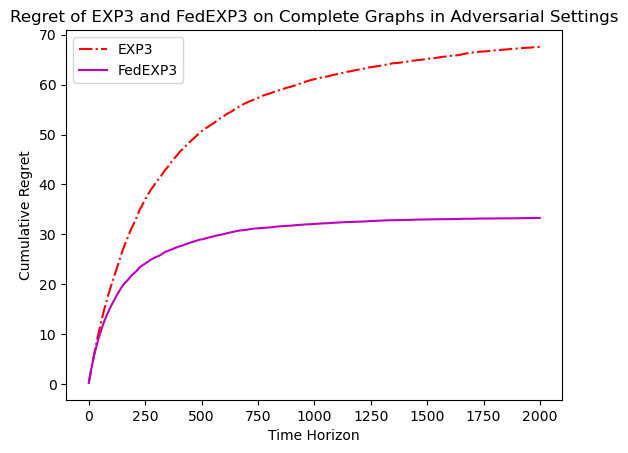

In [5]:
regret_fedexp3 = np.mean(regret_list, 0)
regret_exp3 = np.mean(regret_exp3_list, 0)
x_axis = np.arange(len(regret_fedexp3))
plot_data_o = np.transpose(np.array(regret_fedexp3)).reshape((2000,1))
plot_data_o_exp3 = np.transpose(np.array(regret_exp3)).reshape((2000,1))

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)


plt.plot(x_axis,plot_data_o_exp3, label='EXP3',color='r', linestyle = '-.')

plt.plot(x_axis,plot_data_o, label='FedEXP3',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.title('Regret of EXP3 and FedEXP3 on Complete Graphs in Adversarial Settings')


plt.legend()
plt.show()

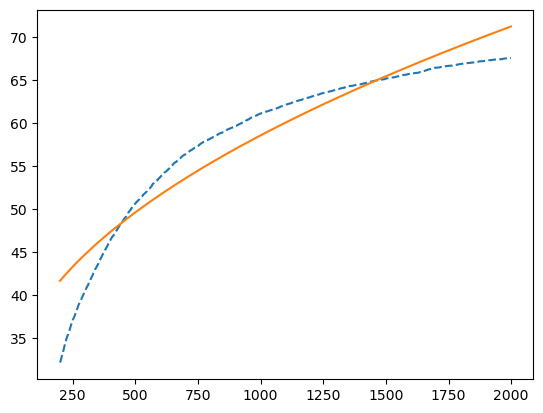

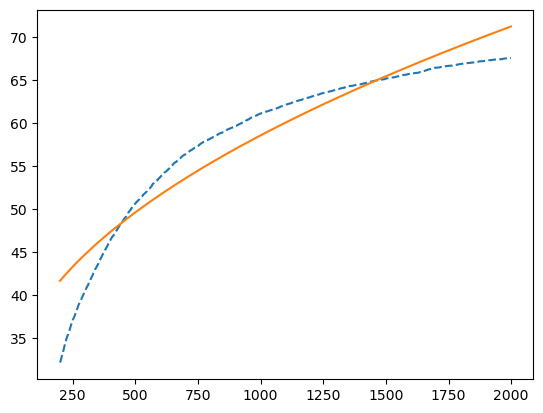

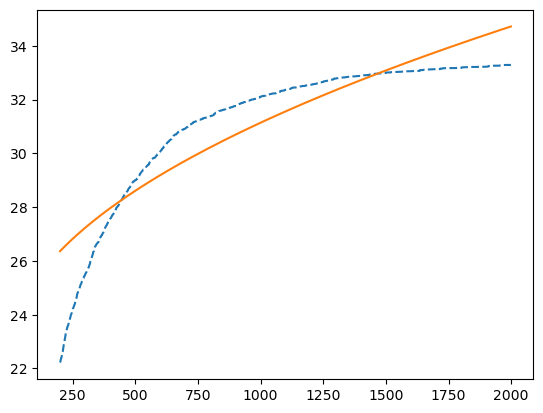

In [9]:
regret_dict = {}
EXP3 = plot_data_o_exp3
FedEXP3 = plot_data_o
regret_dict['EXP3'] = EXP3
regret_dict['FedEXP3'] = FedEXP3
alg = ['EXP3', 'FedEXP3']


#log fit 
from scipy.optimize import curve_fit

def sqrt_func(x, D, E):
    y = D*np.sqrt(x+1) + E
    return y

coeff = {}
fit = []

for i in np.arange(2):
    
    tmp = regret_dict[alg[i]]
    x = x_axis[200:].flatten()
    y = tmp[200:].flatten()

    parameters, covariance = curve_fit(sqrt_func, x, y)
    fit_D = parameters[0]
    fit_E = parameters[1]
    
    coeff[alg[i]] = fit_D

    fit_sqrt = sqrt_func(x, fit_D, fit_E)

    plt.figure()

    plt.plot(x, y, '--', label='data')
    plt.plot(x, fit_sqrt, '-', label='fit')
    fit.append(fit_sqrt)
    plt.show()


In [10]:
coeff

{'EXP3': 0.9670038212452124, 'FedEXP3': 0.2736654317272921}

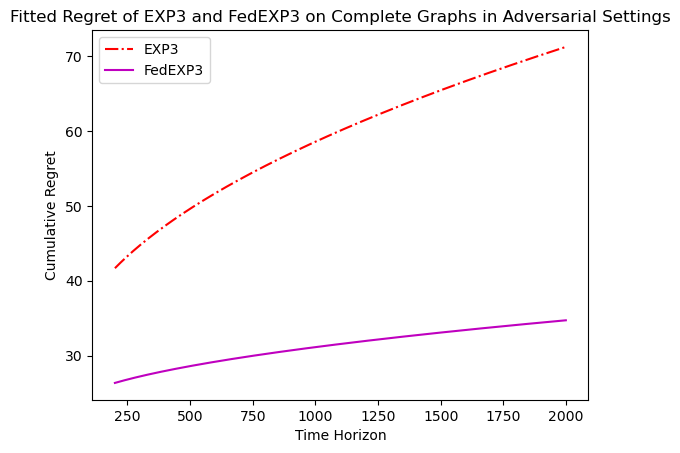

In [14]:
x = x_axis[200:].flatten()
plt.plot(x,fit[0], label='EXP3',color='r', linestyle = '-.')

plt.plot(x,fit[1], label='FedEXP3',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.title('Fitted Regret of EXP3 and FedEXP3 on Complete Graphs in Adversarial Settings')


plt.legend()
plt.show()

In [13]:
import json

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
dumped = json.dumps(regret_dict, cls=NumpyEncoder)

with open("linear.json", "w") as outfile: 
    json.dump(dumped, outfile)
x = x_axis[200:].flatten()
plt.plot(x,fit[0], label='EXP3',color='r', linestyle = '-.')

plt.plot(x,fit[1], label='FedEXP3',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.title('Fitted Regret of EXP3 and FedEXP3 on Complete Graphs in Adversarial Settings')


plt.legend()
plt.show()

In [33]:
with open('sublinear_12.txt', 'w') as f:
    print(regret_dict, file=f)

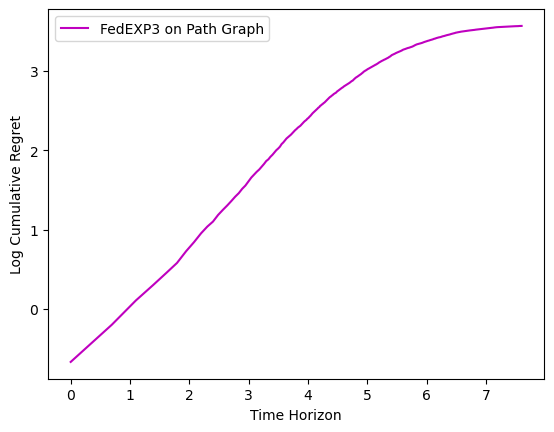

array([1.21377012])

In [173]:
plt.plot(np.log(x_axis[1:]),np.log(plot_data_o[1:]),  label='FedEXP3 on Path Graph',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Log Cumulative Regret')

plt.legend()
plt.show()

X= np.reshape(np.log(x_axis[1:]),(len(x_axis[1:]),-1))
y = np.log(plot_data_o[1:])
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
reg.coef_
reg.intercept_

In [174]:
import statsmodels.api as sm
X_train_lm = sm.add_constant(X)
lm = sm.OLS(y, X_train_lm).fit()
print(lm.summary())

#since M = T^{1/3}
#the total order in T is as follows
#order = x1 + 1/3*const
order = reg.coef_ + 1/3*reg.intercept_
diff = np.abs(order - 2/3)/(2/3)
print(order.item(),diff.item())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     8210.
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:13:54   Log-Likelihood:                 802.49
No. Observations:                1999   AIC:                            -1601.
Df Residuals:                    1997   BIC:                            -1590.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2138      0.024     49.712      0.0

In [15]:
#problem instance 
T = 2000
eta = 8*(2000**(-2/15))
M = int(2000**(2/15)) 
d = eta*M/8
epsilon = np.sqrt(1/eta)*(M**2)*(T**(-1/3))

In [16]:
M, d, epsilon

(2, 0.72592652049981, 0.18631178740808066)

In [17]:
#shuffling bandits 

import os
import datetime
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
class HomoBandit_0(Dataset):
    def __init__(self, n_epochs, n_agents, n_arms, rng) -> None:
        super().__init__()
        global_means = [1/2, 1/2]
        L = np.array(
            [rng.binomial(1, p, size=(n_epochs, n_agents)) for p in global_means], 
            dtype=np.float32
        )
        self.data = np.transpose(L, (1, 2, 0))
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]

    def cumloss_of_best_arm(self):
        true_loss = np.mean(self.data, axis=1)
        cum_losses = np.cumsum(true_loss, axis=0)
        best_arm = np.argmin(cum_losses[-1,])
        return cum_losses[:,best_arm]
        

class StoShuActBandit(HomoBandit_0):
    def __init__(self, n_epochs, n_agents, n_arms, activate_size, rng) -> None:
        super().__init__(n_epochs, n_agents, n_arms, rng)
        period = int(d)+1
        print(period)
        for t in range(n_epochs):
            if t%period== 0:
                special_idx = rng.choice(
                int((n_agents)/4)+1,
                size=1,
                replace=False
            )
                means = [1/2,1/2+epsilon]
                L_1 = np.array(
            [rng.binomial(1, p, size=(period, 1)) for p in means], 
            dtype=np.float32
        )
                self.data[t:(t+period),special_idx,:] = np.transpose(L_1, (1, 2, 0))
            non_selected_idx = rng.choice(
                n_agents,
                size=n_agents - activate_size,
                replace=False
            )
            self.data[t,non_selected_idx,:] = 0

In [18]:
def main_shuffle(config):
    use_cuda = torch.cuda.is_available()
    config['device'] = torch.device("cuda" if use_cuda else "cpu")
    rng = torch.Generator(device=config['device'])
    rng.manual_seed(config['seed'])

    # Create dataset
    env = config['env'].split('-')[0]
    if env == "HomoBandit":
        train_data = fbe.HomoBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            np.random.default_rng(
                int(config['env'].split('-')[-1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfActBandit':
        train_data = fbe.StoActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfFixActBandit':
        train_data = fbe.FixActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'StoShuActBandit':
        train_data = StoShuActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    else:
        raise NotImplementedError("The "+env+" environment has not been implemented.")
    train_loader = DataLoader(
        train_data,
        batch_size=1, 
        shuffle=False
    )
    # compute cumulative loss of the best arm in hindsight
    best_cumu_loss = train_data.cumloss_of_best_arm()

    # Specify communcation network
    network = config['network'].split('-')[0]
    if network == 'COMPLETE':
        graph = nx.complete_graph(config['n_agents'])
    elif network == 'PATH':
        graph = nx.path_graph(config['n_agents'])
    elif network == 'NONE':
        graph = nx.from_numpy_array(
            np.zeros([
                config['n_agents'], config['n_agents']
            ])
        )
    elif network == 'GRID':
        graph = nx.grid_graph([
            int(np.sqrt(config['n_agents'])),
            int(np.sqrt(config['n_agents']))
        ])
    elif network == 'RGG':
        r = float(config['network'].split('-')[1])
        # threshold = np.sqrt(np.log(config['n_agents']) ** 1.1 / config['n_agents'])
        # if r  < threshold:
        #     raise ValueError(
        #         'Please choose r >= ' + str(threshold)
        #     )
        graph = nx.random_geometric_graph(
            config['n_agents'], 
            r,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    elif network == 'ER':
        p = float(config['network'].split('-')[1])
        graph = nx.fast_gnp_random_graph(
            config['n_agents'], 
            p,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    else:
        raise NotImplementedError("The "+config['network']+" network has not been implemented.")
    comm_net = fba.CommNet(graph)

    # Specify the gossip
    if config['network'] == 'NONE':
        gossip_numpy = np.eye(config['n_agents'])
        spectral_gap = 0
    elif config['gossip'] == 'MaxDegree':
        gossip_numpy, spectral_gap = comm_net.max_deg_gossip(spectral_gap=True)
    elif config['gossip'] == 'Fast-SDP':
        gossip_numpy, spectral_gap = comm_net.fast_gossip('SDP', spectral_gap=True)
    else:
        raise NotImplementedError("The "+config['gossip']+" mechanism has not been implemented.")
    gossip = torch.tensor(gossip_numpy, device=config['device'])

    # Create FedExp3
    agent = fba.FedExp3(
        config['n_agents'],
        config['n_arms'],
        gossip, 
        config['lr'],
        expr_scheduler=fba.cube_root_scheduler(config['gamma']),
        device=config['device']
    )

    
    # Initialize WANDB
    if config['WANDB']:
        wandb.init(
            project=config['proj'], 
            reinit=True, 
            config=config, 
            job_type=config['jobtype']
        )
        prob_imgs = []

    cumu_loss = 0
    regret = []
    rounds = len(train_loader)
    for i, loss_matrix in tqdm(enumerate(train_loader), total=rounds):
        L_t = torch.squeeze(loss_matrix, 0).to(config['device'])
        # make actions
        actions, probs = agent.action(rng)
        # compute cumulative losses
        #print(L_t.shape, torch.transpose(actions.float(), 1, 0).shape)
        cumu_loss += torch.matmul(
            torch.mean(L_t, dim=0),
            torch.transpose(actions.float(), 1, 0)
        )
        # update
        agent.update(L_t, actions, probs)
        
        regret.append(torch.mean(cumu_loss).item() - best_cumu_loss[i])
        #print(regret)

        # logging
        if config['WANDB']:
            wandb.log({
                'mean': torch.mean(cumu_loss).item() - best_cumu_loss[i],
                'max': torch.max(cumu_loss).item()- best_cumu_loss[i],
            })
            if i % (config['horizon'] // 10) == 0:
                prob_imgs.append(
                    wandb.Image(
                        Image.fromarray(
                            np.uint8(cm.viridis(probs.tolist())*255)
                        )
                    )
                )

    if config['WANDB']:
        wandb.log({"visual_probs": prob_imgs})
        wandb.log({'mixing_time': spectral_gap ** (-1/3)})
        wandb.finish()
    
    return regret 


In [19]:
def main_shuffle_EXP3(config):
    use_cuda = torch.cuda.is_available()
    config['device'] = torch.device("cuda" if use_cuda else "cpu")
    rng = torch.Generator(device=config['device'])
    rng.manual_seed(config['seed'])

    # Create dataset
    env = config['env'].split('-')[0]
    if env == "HomoBandit":
        train_data = fbe.HomoBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            np.random.default_rng(
                int(config['env'].split('-')[-1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfActBandit':
        train_data = fbe.StoActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfFixActBandit':
        train_data = fbe.FixActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'StoShuActBandit':
        train_data = StoShuActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    else:
        raise NotImplementedError("The "+env+" environment has not been implemented.")
    train_loader = DataLoader(
        train_data,
        batch_size=1, 
        shuffle=False
    )
    # compute cumulative loss of the best arm in hindsight
    best_cumu_loss = train_data.cumloss_of_best_arm()

    # Specify communcation network
    network = config['network'].split('-')[0]
    if network == 'COMPLETE':
        graph = nx.complete_graph(config['n_agents'])
    elif network == 'PATH':
        graph = nx.path_graph(config['n_agents'])
    elif network == 'NONE':
        graph = nx.from_numpy_array(
            np.zeros([
                config['n_agents'], config['n_agents']
            ])
        )
    elif network == 'GRID':
        graph = nx.grid_graph([
            int(np.sqrt(config['n_agents'])),
            int(np.sqrt(config['n_agents']))
        ])
    elif network == 'RGG':
        r = float(config['network'].split('-')[1])
        # threshold = np.sqrt(np.log(config['n_agents']) ** 1.1 / config['n_agents'])
        # if r  < threshold:
        #     raise ValueError(
        #         'Please choose r >= ' + str(threshold)
        #     )
        graph = nx.random_geometric_graph(
            config['n_agents'], 
            r,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    elif network == 'ER':
        p = float(config['network'].split('-')[1])
        graph = nx.fast_gnp_random_graph(
            config['n_agents'], 
            p,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    else:
        raise NotImplementedError("The "+config['network']+" network has not been implemented.")
    comm_net = fba.CommNet(graph)

    # Specify the gossip
    if config['network'] == 'NONE':
        gossip_numpy = np.eye(config['n_agents'])
        spectral_gap = 0
    elif config['gossip'] == 'MaxDegree':
        gossip_numpy, spectral_gap = comm_net.max_deg_gossip(spectral_gap=True)
    elif config['gossip'] == 'Fast-SDP':
        gossip_numpy, spectral_gap = comm_net.fast_gossip('SDP', spectral_gap=True)
    else:
        raise NotImplementedError("The "+config['gossip']+" mechanism has not been implemented.")
    #gossip = torch.tensor(gossip_numpy, device=config['device'])
    
    
    degrees = [val for (node, val) in graph.degree()]
    D = np.diag(degrees)
    gossip_numpy = np.eye(len(degrees))
    gossip = torch.tensor(gossip_numpy, device=config['device'])

    # Create FedExp3
    agent = fba.FedExp3(
        config['n_agents'],
        config['n_arms'],
        gossip, 
        config['lr'],
        expr_scheduler=fba.cube_root_scheduler(config['gamma']),
        device=config['device']
    )

    
    # Initialize WANDB
    if config['WANDB']:
        wandb.init(
            project=config['proj'], 
            reinit=True, 
            config=config, 
            job_type=config['jobtype']
        )
        prob_imgs = []

    cumu_loss = 0
    regret = []
    rounds = len(train_loader)
    for i, loss_matrix in tqdm(enumerate(train_loader), total=rounds):
        L_t = torch.squeeze(loss_matrix, 0).to(config['device'])
        # make actions
        actions, probs = agent.action(rng)
        # compute cumulative losses
        #print(L_t.shape, torch.transpose(actions.float(), 1, 0).shape)
        cumu_loss += torch.matmul(
            torch.mean(L_t, dim=0),
            torch.transpose(actions.float(), 1, 0)
        )
        # update
        agent.update(L_t, actions, probs)
        
        regret.append(torch.mean(cumu_loss).item() - best_cumu_loss[i])
        #print(regret)

        # logging
        if config['WANDB']:
            wandb.log({
                'mean': torch.mean(cumu_loss).item() - best_cumu_loss[i],
                'max': torch.max(cumu_loss).item()- best_cumu_loss[i],
            })
            if i % (config['horizon'] // 10) == 0:
                prob_imgs.append(
                    wandb.Image(
                        Image.fromarray(
                            np.uint8(cm.viridis(probs.tolist())*255)
                        )
                    )
                )

    if config['WANDB']:
        wandb.log({"visual_probs": prob_imgs})
        wandb.log({'mixing_time': spectral_gap ** (-1/3)})
        wandb.finish()
    
    return regret 


In [ ]:
#FedEXP3 - Large M without shuffling; theorem 8 
itr = 50
regret_list_shuffle = []
regret_exp3_list_shuffle = []
for i in np.arange(itr):
    config = dict(
    proj = 'FedExp3',
    env = 'StoShuActBandit-5',
    network = 'PATH',
    gossip = 'MaxDegree',
    n_agents = 20,
    n_arms = 2,                 
    horizon = 2000,                  
    lr = .1,
    gamma = 0.01,
    seed = 0,
    WANDB = False,
    jobtype = 'test'
)
    regret_fedexp3_shuffle = main_shuffle(config)
    regret_exp3_shuffle = main_shuffle_EXP3(config)
    regret_list_shuffle.append(regret_fedexp3_shuffle)
    regret_exp3_list_shuffle.append(regret_exp3_shuffle)

1


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 5128.72it/s]


1


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 5037.15it/s]


1


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 5272.04it/s]


1


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 4829.54it/s]


1


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 4694.32it/s]


1


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 5018.92it/s]


1


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 4932.59it/s]


1


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 5069.96it/s]


1


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 4791.66it/s]

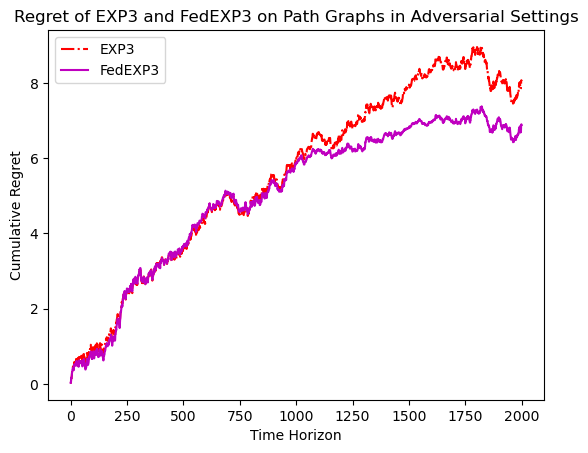

In [27]:
regret_fedexp3_shuffle = np.mean(regret_list_shuffle, 0)
regret_exp3_shuffle = np.mean(regret_exp3_list_shuffle, 0)
x_axis = np.arange(len(regret_fedexp3_shuffle))
plot_data_o = np.transpose(np.array(regret_fedexp3_shuffle)).reshape((2000,1))
plot_data_o_exp3 = np.transpose(np.array(regret_exp3_shuffle)).reshape((2000,1))

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)


plt.plot(x_axis,plot_data_o_exp3, label='EXP3',color='r', linestyle = '-.')

plt.plot(x_axis,plot_data_o, label='FedEXP3',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.title('Regret of EXP3 and FedEXP3 on Path Graphs in Adversarial Settings')


plt.legend()
plt.show()

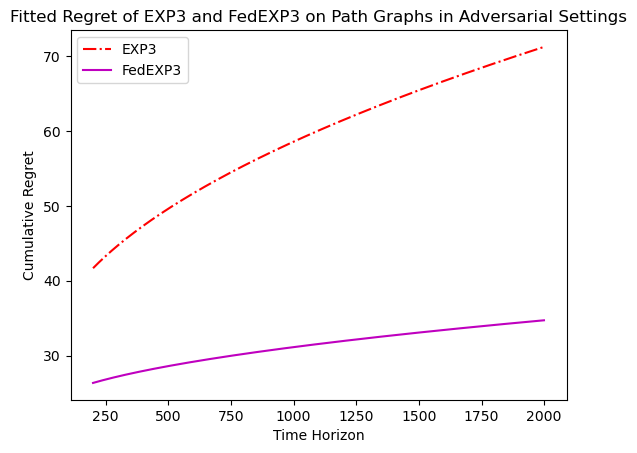

In [29]:
import json

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
dumped = json.dumps(regret_dict, cls=NumpyEncoder)

with open("sulinear_23.json", "w") as outfile: 
    json.dump(dumped, outfile)
x = x_axis[200:].flatten()
plt.plot(x,fit[0], label='EXP3',color='r', linestyle = '-.')

plt.plot(x,fit[1], label='FedEXP3',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.title('Fitted Regret of EXP3 and FedEXP3 on Path Graphs in Adversarial Settings')


plt.legend()
plt.show()

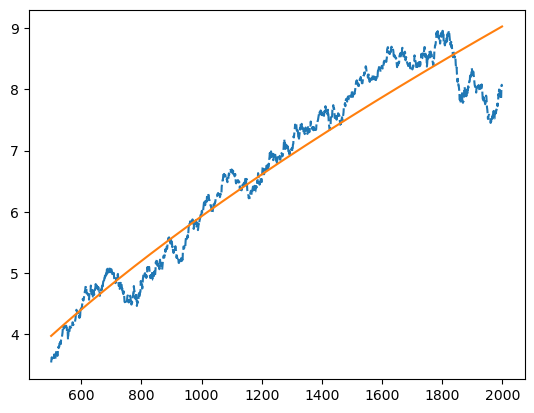

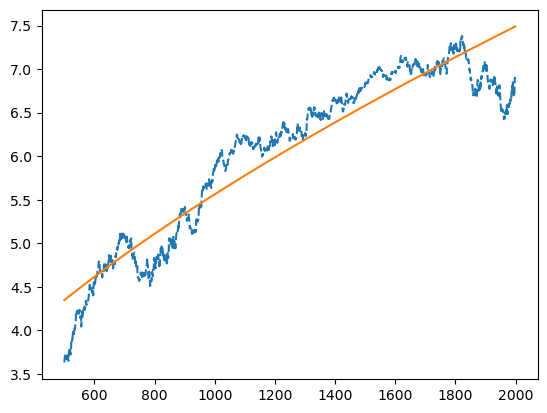

In [35]:
regret_dict = {}
EXP3 = plot_data_o_exp3
FedEXP3 = plot_data_o
regret_dict['EXP3'] = EXP3
regret_dict['FedEXP3'] = FedEXP3
alg = ['EXP3', 'FedEXP3']


#log fit 
from scipy.optimize import curve_fit

def sqrt_func(x, D, E):
    y = D*np.power(x, 2/3) + E
    return y

coeff = {}

for i in np.arange(2):
    
    tmp = regret_dict[alg[i]]
    x = x_axis[500:].flatten()
    y = tmp[500:].flatten()

    parameters, covariance = curve_fit(sqrt_func, x, y)
    fit_D = parameters[0]
    fit_E = parameters[1]
    
    coeff[alg[i]] = fit_D

    fit_sqrt = sqrt_func(x, fit_D, fit_E)

    plt.figure()

    plt.plot(x, y, '--', label='data')
    plt.plot(x, fit_sqrt, '-', label='fit')
    plt.show()


In [36]:
coeff

{'EXP3': 0.05277423336970685, 'FedEXP3': 0.03281086745257607}

In [38]:
with open('sublinear_23.txt', 'w') as f:
    print(regret_dict, file=f)

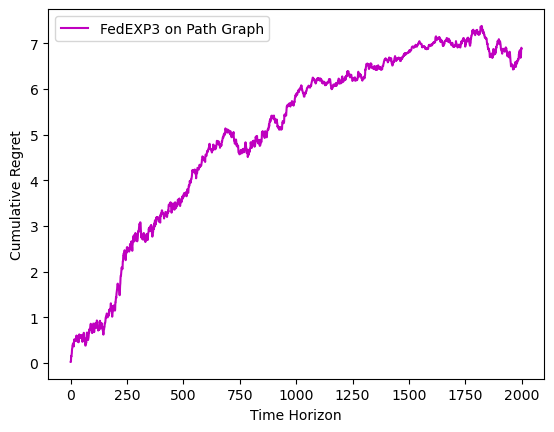

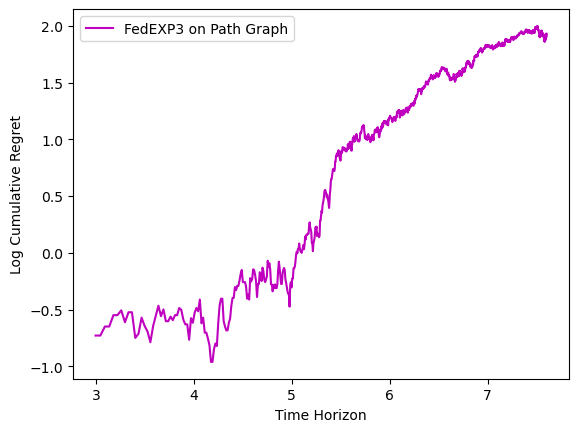

[[0.70489697]] [-3.20148739]


In [182]:
regret_fedexp3 = np.mean(regret_list, 0)
x_axis = np.arange(len(regret_fedexp3))
plot_data_o = np.transpose(np.array(regret_fedexp3)).reshape((2000,1))
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)

plt.plot(x_axis,plot_data_o,  label='FedEXP3 on Path Graph',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')

plt.legend()
plt.show()



plt.plot(np.log(x_axis[20:]),np.log(plot_data_o[20:]),  label='FedEXP3 on Path Graph',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Log Cumulative Regret')

plt.legend()
plt.show()

X= np.reshape(np.log(x_axis[20:]),(len(x_axis[20:]),-1))
y = np.log(plot_data_o[20:])
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
print(reg.coef_,reg.intercept_)



In [184]:
#since M is small and we treat it as constant 
#the total order in T is as follows
#order = x1 
order = reg.coef_ 
diff = np.abs(order - 2/3)/(2/3)
print(order.item(),diff.item())

0.7048969672659097 0.05734545089886456


In [185]:
import statsmodels.api as sm
X_train_lm = sm.add_constant(X)
lm = sm.OLS(y, X_train_lm).fit()
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 2.918e+04
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:30:02   Log-Likelihood:                 784.78
No. Observations:                1980   AIC:                            -1566.
Df Residuals:                    1978   BIC:                            -1554.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2015      0.028   -115.705      0.0

In [159]:
#total order is as follow
order = reg.coef_ + 2/15*reg.intercept_

In [160]:
order

array([[0.22630663]])

In [ ]:
def main_shuffle_EXP3(config):
    use_cuda = torch.cuda.is_available()
    config['device'] = torch.device("cuda" if use_cuda else "cpu")
    rng = torch.Generator(device=config['device'])
    rng.manual_seed(config['seed'])

    # Create dataset
    env = config['env'].split('-')[0]
    if env == "HomoBandit":
        train_data = fbe.HomoBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            np.random.default_rng(
                int(config['env'].split('-')[-1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfActBandit':
        train_data = fbe.StoActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfFixActBandit':
        train_data = fbe.FixActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'StoShuActBandit':
        train_data = StoShuActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    else:
        raise NotImplementedError("The "+env+" environment has not been implemented.")
    train_loader = DataLoader(
        train_data,
        batch_size=1, 
        shuffle=False
    )
    # compute cumulative loss of the best arm in hindsight
    best_cumu_loss = train_data.cumloss_of_best_arm()

    # Specify communcation network
    network = config['network'].split('-')[0]
    if network == 'COMPLETE':
        graph = nx.complete_graph(config['n_agents'])
    elif network == 'PATH':
        graph = nx.path_graph(config['n_agents'])
    elif network == 'NONE':
        graph = nx.from_numpy_array(
            np.zeros([
                config['n_agents'], config['n_agents']
            ])
        )
    elif network == 'GRID':
        graph = nx.grid_graph([
            int(np.sqrt(config['n_agents'])),
            int(np.sqrt(config['n_agents']))
        ])
    elif network == 'RGG':
        r = float(config['network'].split('-')[1])
        # threshold = np.sqrt(np.log(config['n_agents']) ** 1.1 / config['n_agents'])
        # if r  < threshold:
        #     raise ValueError(
        #         'Please choose r >= ' + str(threshold)
        #     )
        graph = nx.random_geometric_graph(
            config['n_agents'], 
            r,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    elif network == 'ER':
        p = float(config['network'].split('-')[1])
        graph = nx.fast_gnp_random_graph(
            config['n_agents'], 
            p,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    else:
        raise NotImplementedError("The "+config['network']+" network has not been implemented.")
    comm_net = fba.CommNet(graph)

    # Specify the gossip
    if config['network'] == 'NONE':
        gossip_numpy = np.eye(config['n_agents'])
        spectral_gap = 0
    elif config['gossip'] == 'MaxDegree':
        gossip_numpy, spectral_gap = comm_net.max_deg_gossip(spectral_gap=True)
    elif config['gossip'] == 'Fast-SDP':
        gossip_numpy, spectral_gap = comm_net.fast_gossip('SDP', spectral_gap=True)
    else:
        raise NotImplementedError("The "+config['gossip']+" mechanism has not been implemented.")
    #gossip = torch.tensor(gossip_numpy, device=config['device'])
    
    
    degrees = [val for (node, val) in graph.degree()]
    D = np.diag(degrees)
    gossip_numpy = np.eye(len(degrees))
    gossip = torch.tensor(gossip_numpy, device=config['device'])

    # Create FedExp3
    agent = fba.FedExp3(
        config['n_agents'],
        config['n_arms'],
        gossip, 
        config['lr'],
        expr_scheduler=fba.cube_root_scheduler(config['gamma']),
        device=config['device']
    )

    
    # Initialize WANDB
    if config['WANDB']:
        wandb.init(
            project=config['proj'], 
            reinit=True, 
            config=config, 
            job_type=config['jobtype']
        )
        prob_imgs = []

    cumu_loss = 0
    regret = []
    rounds = len(train_loader)
    for i, loss_matrix in tqdm(enumerate(train_loader), total=rounds):
        L_t = torch.squeeze(loss_matrix, 0).to(config['device'])
        # make actions
        actions, probs = agent.action(rng)
        # compute cumulative losses
        #print(L_t.shape, torch.transpose(actions.float(), 1, 0).shape)
        cumu_loss += torch.matmul(
            torch.mean(L_t, dim=0),
            torch.transpose(actions.float(), 1, 0)
        )
        # update
        agent.update(L_t, actions, probs)
        
        regret.append(torch.mean(cumu_loss).item() - best_cumu_loss[i])
        #print(regret)

        # logging
        if config['WANDB']:
            wandb.log({
                'mean': torch.mean(cumu_loss).item() - best_cumu_loss[i],
                'max': torch.max(cumu_loss).item()- best_cumu_loss[i],
            })
            if i % (config['horizon'] // 10) == 0:
                prob_imgs.append(
                    wandb.Image(
                        Image.fromarray(
                            np.uint8(cm.viridis(probs.tolist())*255)
                        )
                    )
                )

    if config['WANDB']:
        wandb.log({"visual_probs": prob_imgs})
        wandb.log({'mixing_time': spectral_gap ** (-1/3)})
        wandb.finish()
    
    return regret 
